<a href="https://colab.research.google.com/github/remre/StriveSchool-ai/blob/main/w6_deepl/sol/d5/FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

import torch
from torch import nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import  DataLoader

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()


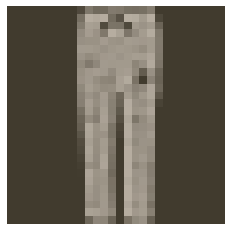

In [4]:
image, label = next(iter(trainloader))
imshow(image[0,:]);

In [5]:
image.shape

torch.Size([64, 1, 28, 28])

In [50]:
## TODO: Your network here
class NeuralNetworkk(nn.Module):
    def __init__(self, input_dim, num_hidden1, num_hidden2):
        super().__init__()
        #self.conv1 = nn.Conv2d(input_dim,num_hidden1,kernel_size = 2)
        self.fc1 = nn.Linear(input_dim, num_hidden1)
        self.drop = nn.Dropout(p = 0.25)
        self.fc2 = nn.Linear(num_hidden1, num_hidden2)
        self.fc3 = nn.Linear(num_hidden2, 10)
        
    def forward(self,x):
      #for layer 1 
      #x = x.flatten()
      #x = self.conv1(x)
      x = self.fc1(x)
      x = F.relu(x)
      x = self.drop(x)
      x = self.fc2(x)
      x = F.relu(x)
      x = self.fc3(x)
      output = F.softmax(x, dim=1)
      return output
model = NeuralNetworkk(784, 300,100)

In [55]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
error = nn.CrossEntropyLoss()

learning_rate = 0.001
loss_funcc = nn.NLLLoss()
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam( model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = F.nll_loss
model.eval()
print(model)

NeuralNetworkk(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [26]:
device

device(type='cuda', index=0)

In [56]:
# Training the Model
num_epochs = 20
for epoch in range(num_epochs):
    for batch_idx,(data,targets) in enumerate(trainloader):
        # Get Data to CUDA if possible
        data = data.to(device=device)
        target = targets.to(device=device)
        # Get to correct shape
        data = data.reshape(data.shape[0],-1)
        
        # Forward
        score = model(data)
        loss = error(score,target)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient Descent or Adam Step
        optimizer.step()

In [57]:
def check_accuracy(loader,model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device = device)
            y = y.to(device = device)
            
            x = x.reshape(x.shape[0],-1)

            scores = model(x)
            _,predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}")
    model.train()
    

In [58]:
check_accuracy(trainloader,model)
check_accuracy(testloader,model)

Got 53430 / 60000 with accuracy 89.05
Got 8630 / 10000 with accuracy 86.30


In [ ]:
img = Image.open("deneme.jpeg")

img


convert_tensor = transforms.ToTensor()

convert_tensor(img)

In [39]:
data.shape[0],-1

(32, -1)